# ROI detection (segmentation) defacer ver 2.0

## Asan Medical Center

  
#### &nbsp;

In [1]:
import os
import glob
import math
import time
import datetime as dt
import numpy as np
import nibabel as nib
import random
from scipy import ndimage
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
from matplotlib import colors

from keras import backend as K
from keras.optimizers import Adam, SGD


from keras.models import Model
from keras.utils import to_categorical

from skimage.filters import threshold_triangle
from skimage.morphology import remove_small_holes
#from skimage.measure import marching_cubes_lewiner

from keras import layers, initializers, regularizers, constraints
from keras.layers import Layer, InputSpec
from keras.layers import Dense, Activation, Flatten, Input, Convolution3D, MaxPooling3D, UpSampling3D, ZeroPadding3D,  BatchNormalization, concatenate, Conv3D
from keras.layers import Lambda, ReLU, Multiply, Reshape, ThresholdedReLU
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, ZeroPadding3D, Cropping3D, Conv3DTranspose, GlobalAveragePooling3D
from keras.layers import BatchNormalization, GaussianNoise
from keras.layers import concatenate, add, multiply
from keras.layers import Activation


Using TensorFlow backend.


# Load Data

In [2]:
config = dict() #configuration info

In [3]:
#configure parameter & hyper parameter
config['aug_index']= 3 # generate augmentation images per single training data.
config["img_channel"] = 1
config["num_multilabel"] = 5 # the number of label (channel last)
config["noise"] = 0.1
config["batch_size"] = 1 # 3D segmentation learning needs too large GPU memory to increase batch size. # this script is optimized for single batch size 
config["resizing"] = True #True -> resize input image for learning. if you don't have enough GPU memory.
config["input_shape"] = [128, 128, 128, 1] # smaller GPU memory smaller image size

    
config["epochs"] = 100 

In [4]:
config["path_image"] = '/home/jupyter/project/cbvdamcct/image'
config["path_label"] = '/home/jupyter/project/cbvdamcct/label'




#Load .nii.gz files
list_train_image = glob.glob(os.path.join(config["path_image"],'*.nii.gz'))
list_train_label = glob.glob(os.path.join(config["path_label"],'*.nii.gz'))

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_valid_test, y_train, y_valid_test = train_test_split(
    list_train_image, 
    list_train_label,
    shuffle = True,
    test_size=2,
    random_state=8)

x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid_test, 
    y_valid_test,
    shuffle = True,
    test_size=1,
    random_state=8)


In [6]:
# 제대로 들어갔는지 확인 
print ( 
    'Training set : ', len(x_train),
    '\n\nValidation set : ', len(x_valid), 
    '\n\nTest set : ', len(x_test)
    
)

Training set :  3 

Validation set :  1 

Test set :  1


# Data Augmentation

In [7]:
import keras_image_preprocessing
datagen = keras_image_preprocessing.ImageDataGenerator(
                                        rotation_range=[10.,10.,10.],
                                        zoom_range=[0.90, 1.10],
                                        width_shift_range=0.10,
                                        height_shift_range=0.10,
                                        depth_shift_range=0.10,
                                        shear_range=0.20,
                                        horizontal_flip=False,
                                        vertical_flip=False,
                                        depthly_flip=False,
                                        axis_transpose=False,
                                        fill_mode='constant',cval=0.)

In [8]:
def data_aug(img, label, color_reversal=True):
    
    seed = np.random.randint(100000)
    img = np.transpose(img,(0,3,2,1,4))
    img = img[:,:,::-1,:,:]
    label = np.transpose(label,(0,3,2,1,4))
    label = label[:,:,::-1,:,:]
    for img in datagen.flow(img, batch_size=1, seed = seed ):
        
        if np.random.random() < 0.7:
        	img = img*(seed/100000)
            
        break
        
    for label in datagen.flow(label, batch_size=1, seed = seed):
        
        break
    return img, label

# 3D Unet Model 

In [9]:
def resize(data, img_dep=config["input_shape"][0], img_cols=config["input_shape"][1], img_rows=config["input_shape"][2]):
    resize_factor = (img_dep/data.shape[0], img_cols/data.shape[1], img_rows/data.shape[2])
    data = ndimage.zoom(data, resize_factor, order=0, mode='constant', cval=0.0)
    return data
'''
ndimage.zoom(어레이 데이터 인풋,축별로zoom factor. 숫자하나면 각축에 적용.,
The order of the spline interpolation. 0-5까지 옵션있음 ,

'''

# loss function

def dice_score(y_true, y_pred):
    smooth = 1e-08
    label_length = y_pred.get_shape().as_list()[-1] #the number of label (channel last)
    
    loss = 0    
    for num_labels in range(label_length):
        y_true_f = K.flatten(y_true[..., num_labels])
        y_pred_f = K.flatten(y_pred[..., num_labels])
        intersection = K.sum(y_true_f * y_pred_f)
        if K.sum(y_true_f) == 0:
            loss += (1- (K.sum(y_pred_f)/ K.sum(K.flatten(K.ones_like(y_true)))))
        else:
            loss += (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
   
    return loss/label_length 

def dice_loss(y_true, y_pred):
    return 1-dice_score(y_true, y_pred) # + 0.01*K.categorical_crossentropy(y_true, y_pred)
'''
Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    
'''


def tversky_loss(beta): # beta : [0,1] the bigger beta, the more penaly on False Positive
    def t_loss(y_true, y_pred):
        loss = 0
        label_length = y_pred.get_shape().as_list()[-1] # the number of label (channel last)
        smooth = 1e-08
        
        for num_labels in range(label_length):
            y_true_f = K.flatten(y_true[..., num_labels])
            y_pred_f = K.flatten(y_pred[..., num_labels])
            numerator = K.sum(y_true_f * y_pred_f)
            denominator = y_true_f * y_pred_f + beta * (1 - y_true_f) * y_pred_f + (1 - beta) * y_true_f * (1 - y_pred_f)
            loss += (numerator+ smooth) / (K.sum(denominator) + smooth)
        return 1-(loss / label_length) + 0.1*K.categorical_crossentropy(y_true, y_pred)
        
    return t_loss


def focal_tversky(y_true,y_pred):
    pt_1 = tversky_loss(0.7)(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


    
# keras_contrib.layers.InstanceNormalization
# https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
#InstanceNormalization
def unet_model(input_shape, num_labels, axis=-1, base_filter=16, se_res_block=True, se_ratio=16, noise=0.1, atten_gate=False):
    def conv3d(layer_input, filters, axis=-1, se_res_block=True, se_ratio=-1, down_sizing=True):
        if down_sizing == True:
            layer_input = MaxPooling3D(pool_size=(2, 2, 2))(layer_input)

        d1 = Conv3D(filters, (3, 3, 3), use_bias=False, padding='same')(layer_input)
        d1 = InstanceNormalization(axis=axis)(d1)
        d1 = ReLU()(d1)
        
        d = Conv3D(filters, (3, 3, 3), use_bias=False, padding='same')(d1)
        d = InstanceNormalization(axis=axis)(d)
        if se_res_block == True:
            se = GlobalAveragePooling3D()(d)
            se = Dense(filters // se_ratio, activation='relu')(se)
            se = Dense(filters, activation='sigmoid')(se)
            se = Reshape([1, 1, 1, filters])(se)
            d = Multiply()([d, se])
            shortcut = InstanceNormalization(axis=axis)(d1)
            d = add([d, shortcut])
        d = ReLU()(d)
        return d

    def deconv3d(layer_input, skip_input, filters, axis=-1, se_res_block=True, se_ratio=8, atten_gate=False):
        if atten_gate == True:
            gating = Conv3D(filters, (1, 1, 1), use_bias=True,  padding='valid')(layer_input)
            gating = InstanceNormalization(axis=axis)(gating)
            attention = Conv3D(filters, (2, 2, 2), strides=(2, 2, 2), use_bias=False,  padding='valid')(skip_input)
            attention = InstanceNormalization(axis=axis)(attention)
            attention = add([gating, attention])
            attention = ReLU()(attention)
            attention = Conv3D(1, (1, 1, 1), use_bias=False, 
                               padding='same', activation='sigmoid')(attention)
           
            
            attention = UpSampling3D((2, 2, 2))(attention)
            attention = Lambda(lambda x: K.tile(
                x, [1, 1, 1, 1, filters]))(attention)
            skip_input = Multiply()([attention, skip_input])
            
        #one deconv 
        u1 = Conv3DTranspose(filters, (2, 2, 2), strides=(2, 2, 2), use_bias=False,  padding='same')(layer_input)
        u1 = InstanceNormalization(axis=axis)(u1)
        u1 = ReLU()(u1)
        u1 = concatenate([u1, skip_input],axis=axis)
        
        #two conv 
        u2 = Conv3D(filters, (3, 3, 3), use_bias=False,  padding='same')(u1)     
        u2 = InstanceNormalization(axis=axis)(u2)
        u2 = ReLU()(u2)
        u2 = Conv3D(filters, (3, 3, 3), use_bias=False,  padding='same')(u2)
        u2 = InstanceNormalization(axis=axis)(u2)
       
        if se_res_block == True:
            se = GlobalAveragePooling3D()(u2)
            se = Reshape((1, 1, 1, filters))(se)
            se = Dense(filters // se_ratio, activation='relu', use_bias=False)(se)
            se = Dense(filters, activation='sigmoid', use_bias=False)(se)
            se = Reshape([1, 1, 1, filters])(se)
            se = Multiply()([u2, se])
            u2 = add([u2, se])
        u2 = ReLU()(u2)
        
       
        return u2


    
    input_img = Input(shape=input_shape)
    d0 = GaussianNoise(noise)(input_img)

    d0 = conv3d(d0, base_filter, se_res_block=se_res_block, se_ratio=se_ratio, down_sizing=False) #original size
    d1 = conv3d(d0, base_filter*2, se_res_block=se_res_block, se_ratio=se_ratio) # /2 
    d2 = conv3d(d1, base_filter*4, se_res_block=se_res_block, se_ratio=se_ratio) # /4
    d3 = conv3d(d2, base_filter*8, se_res_block=se_res_block, se_ratio=se_ratio) # /8 

    u2 = deconv3d(d3, d2, base_filter*4, se_res_block=se_res_block, se_ratio=se_ratio)
    u1 = deconv3d(u2, d1, base_filter*2, se_res_block=se_res_block, se_ratio=se_ratio)
    u0 = deconv3d(u1, d0, base_filter, se_res_block=se_res_block, se_ratio=se_ratio)
    
    
    output_img = Conv3D(num_labels, kernel_size=1, strides=1, 
                        padding='same', activation='softmax')(u0)
    
    

    model = Model(inputs=input_img, outputs=output_img)   

    return model

In [11]:
model = unet_model(input_shape=config["input_shape"],
                   num_labels=config["num_multilabel"],
                   base_filter=16,
                   se_res_block=True,
                   se_ratio=16,  
                   atten_gate=True
                   )


model.compile(optimizer=Adam(lr=0.0002),loss=dice_loss, metrics=[dice_score])


###  training function

In [12]:
# 5D tensor (batch,img_dep,img_cols,img_rows,img_channel)
def load_batch(x_list,y_list=[]):
    
    image = nib.load(x_list).get_fdata()
#     image= x_list
    if config["resizing"] == True : 
        image = resize(image)
        img_shape = image.shape
    else:
        img_shape = image.shape

    image = np.reshape(image,(1 ,img_shape[0], img_shape[1], img_shape[2] , 1)) # batch, z ,y, x , ch
    n_image = (image-np.min(image))/(np.max(image)-np.min(image))
  
    label=0
    if y_list!=[]:
        labels = nib.load(y_list).get_fdata()
#         labels = labels.T
#         labels = labels[:,::-1,:]
        if config["resizing"] == True : 
            labels = resize(labels)
            lb_shape = labels.shape
        else:
            lb_shape = labels.shape
            

        onehot = to_categorical(labels)     
        label = np.reshape(onehot,(1 ,lb_shape[0], lb_shape[1], lb_shape[2], config["num_multilabel"] ))

    
     
    return n_image,label
       


In [13]:
def train(x_train,y_train):
    
    train_dice = []
    count=0
    for i in range(len(x_train)):
        image0, label0 = load_batch(x_train[i],y_train[i])
        train_loss_tmp = model.train_on_batch(image0, label0) #original image training
        train_dice.append(train_loss_tmp[1])
        count+=1
        
        print( '\r'+'\033[91m'+ "complete {} / {} average Metrics : {} , Metrics : {}" 
                  .format(count, len(x_train)+len(x_train)*config['aug_index'], np.mean(np.array(train_dice)) ,train_loss_tmp[1] ) , end="")
        
       
        for index in range(config['aug_index']):     #train augmentation images as the number of config['aug_index']
            image, label = data_aug(image0, label0)
            train_loss_tmp = model.train_on_batch(image, label) 
            
            train_dice.append(train_loss_tmp[1])
            count+=1
            
            print("\rcomplete {} / {} average Metrics : {} , Metrics : {}" 
                  .format(count, len(x_train)+len(x_train)*config['aug_index'], np.mean(np.array(train_dice)) ,train_loss_tmp[1] ) , end="")
        
    train_dice = np.mean(np.array(train_dice))
    return train_dice

def valid(x_valid,y_valid):
    
    valid_dice = []
    for i in range(len(x_valid)):
        image0, label0 = load_batch(x_valid[i],y_valid[i])
        valid_loss_tmp = model.evaluate(image0,label0,verbose=0)
        valid_dice.append(valid_loss_tmp[1])
        for i in range(1):
            image, label = data_aug(image0, label0)
            

            valid_loss_tmp = model.evaluate(image,label,verbose=0)
            valid_dice.append(valid_loss_tmp[1])
            
    valid_dice = np.mean(np.array(valid_dice))
    return valid_dice   

def test(x_test,y_test):
    
    test_dice = []
    for i in range(len(x_test)):
        image, label = load_batch(x_test[i],y_test[i])
        test_loss_tmp = model.evaluate(image,label,verbose=0)
        test_dice.append(test_loss_tmp[1])
            
    #valid_dice = np.mean(np.array(valid_dice))
    return test_dice   

### check configuration

In [14]:
config

{'aug_index': 3,
 'img_channel': 1,
 'num_multilabel': 5,
 'noise': 0.1,
 'batch_size': 1,
 'resizing': True,
 'input_shape': [128, 128, 128, 1],
 'epochs': 100,
 'path_image': '/home/jupyter/project/cbvdamcct/image',
 'path_label': '/home/jupyter/project/cbvdamcct/label'}

# Train - model save

In [15]:
score_check = [0.]
for num_epoch in range(config["epochs"]):
        
    # shuffling training set 
    combined = list(zip(x_train, y_train))
    random.shuffle(combined)
    x_train[:], y_train[:] = zip(*combined)

    
    # training
    train_dice = train(x_train,y_train)

    # validation
    valid_dice = valid(x_valid,y_valid)
    
    
    # model save when validation dice coef. improved
    if np.max(score_check) < valid_dice: 
        model.save('model_contour4.h5')
        print('\nEpochs',num_epoch,'train:',f'{train_dice:.3f}','valid:',f'{valid_dice:.3f}','[saved]', "\t", dt.datetime.now())
    else:
        print('\nEpochs',num_epoch,'train:',f'{train_dice:.3f}','valid:',f'{valid_dice:.3f}', "\t", dt.datetime.now())
    
    score_check.append(valid_dice)
    print('\n')
    
    #early stop option: if there is no improvement during the last 5 epochs, the learning stops.
    if np.max(score_check[-5:]) < np.max(score_check): 
        
        break
        

model.save('model_model_contour_last.h5') # save model at last epoch

complete 12 / 12 average Metrics : 0.04952740669250488 , Metrics : 0.06308706104755402936196
Epochs 0 train: 0.050 valid: 0.065 [saved] 	 2020-11-17 13:40:57.493552


complete 1 / 12 average Metrics : 0.06366405636072159 , Metrics : 0.06366405636072159

KeyboardInterrupt: 

# Model test -test set(labeled data) evaluation



In [17]:
model.load_weights('model_contour4.h5') # load only weight

In [17]:
# onehot results -> argmax
def onehot2label (onehot_array) :
    onehot_array = np.argmax(onehot_array,axis=-1)
    label=onehot_array[...,np.newaxis]

    return label

In [18]:
def view_result (test_num, *args):
    i = test_num
    
    image = bx_data[i]
    '''
    # y axis flip test
    image = image[:,:,::-1,:,:]
    label = label[:,:,::-1,:,:]
    
    image = np.transpose(image,(0,3,2,1,4)) 
    label = np.transpose(label,(0,3,2,1,4))
    '''
    #image =image.T
    results = model.predict(image)
    
    
    groundtruth = onehot2label(y_test[i])
    pred = onehot2label(results)

    
    cmap = colors.ListedColormap(['None', 'red', 'purple', 'blue', 'yellow', 'green']) #rigt eye 1, left eye 2, nose 3, right ear 4, left ear5
    bounds=[0,1,2,3,4,5,6]
    norm = colors.BoundaryNorm(bounds, cmap.N)

   
    for num_slice in args : 
        plt.figure(figsize=(15,10))
        plt.subplot(2,2,1)
        plt.title('GroundTruth axial = {}'.format(num_slice))

        plt.imshow(image[0,:,num_slice,:,0],cmap='gray')

        plt.imshow(groundtruth[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm)
        plt.subplot(2,2,2)
        plt.title('Prediction {}'.format(num_slice))

        plt.imshow(image[0,:,num_slice,:,0],cmap='gray')
        plt.imshow(pred[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm)

        print("axial = {}".format(num_slice),"\nprediction = ",set(list(pred[0,:,num_slice,:,0].flatten())))
        print("ground truth = ", set(list(groundtruth[0,:,num_slice,:,0].flatten())))
        print("\n")


In [19]:
def view_result (image,label, *args):
    image, label = load_batch(image,label)
    

    
    groundtruth = onehot2label(label)
  

    
    cmap = colors.ListedColormap(['None', 'red', 'purple', 'blue', 'yellow', 'green']) #rigt eye 1, left eye 2, nose 3, right ear 4, left ear5
    bounds=[0,1,2,3,4,5,6]
    norm = colors.BoundaryNorm(bounds, cmap.N)

   
    for num_slice in args : 
        plt.figure(figsize=(15,10))
        plt.subplot(2,2,1)
        plt.title('GroundTruth axial = {}'.format(num_slice))

        plt.imshow(image[0,:,num_slice,:,0],cmap='gray')

        plt.imshow(groundtruth[0,:,num_slice,:,0],alpha=0.5,cmap=cmap, norm=norm)

        

      
        print("ground truth = ", set(list(groundtruth[0,:,num_slice,:,0].flatten())))
        print("\n")


ground truth =  {0, 1, 3}


ground truth =  {0, 1, 3}


ground truth =  {0, 2, 3}


ground truth =  {0, 4}


ground truth =  {0, 4}




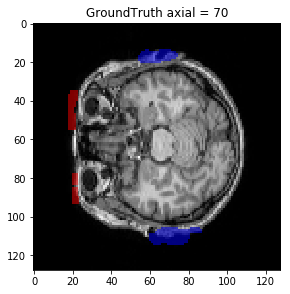

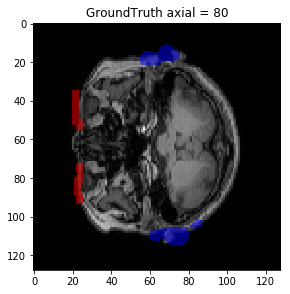

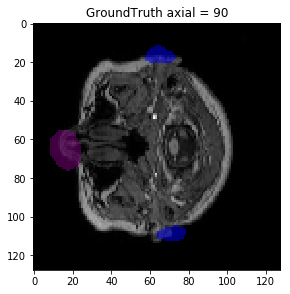

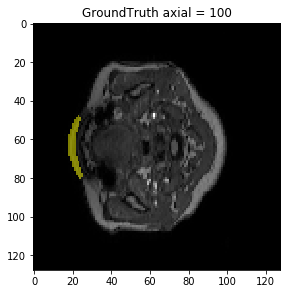

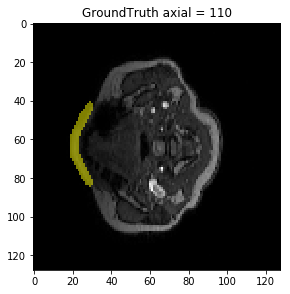

In [188]:
view_result(dcm_img[1],asan_label[1],*(70,80,90,100,110)) 

# EOF